In [93]:
# initialized connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
from scipy import stats

In [2]:
# read pwd string from save file
with open('postgrest_pwd.txt', 'r') as f:
    pwd = f.readline()

In [3]:
# read data from table to datatframe with Month form 201801
table = 'mis_cc_kpi_m'
with pg.connect(database='ktc', user='postgres', password=pwd) as con:
    df = pd.read_sql('select * from ' + table + ' where "month"::bigint >= 201801', con = con)

## Oss Credit card by month
### Approved performance

#### Finalized

In [ ]:
df_gr = df.groupby(['month', 'channel', 'channel_sub'])
df_gr['finalized'].sum().unstack(0).applymap("{:,d}".format)

#### Approve-new

In [ ]:
df_gr['appr_new'].sum().unstack(0).applymap("{:,d}".format)

#### % Appr-rate

In [ ]:
(df_gr['appr'].sum()/df_gr['finalized'].sum()).unstack(0).applymap("{:.0%}".format)

#### Credit limit new

In [ ]:
(df_gr['credit_limit_new'].sum()/df_gr['appr_new'].sum()).unstack(0).applymap("{:,.0f}".format)

#### % active60D

In [ ]:
(df_gr['active60'].sum()/df_gr['appr_new'].sum()).unstack(0).applymap("{:.0%}".format)

In [ ]:
df.groupby(['channel_sub', 'month'])['finalized'].sum().unstack(0).plot()

In [ ]:
df_gr[['finalized', 'appr_new']].sum().stack().unstack(0).applymap("{:,d}".format)

In [ ]:
# group by , sum, reset MultiIndex -> DataFrame
i = df_gr[['finalized', 'appr', 'appr_new']].sum().reset_index()
# create per apr from appr_new / finalzied
i['per_apr'] = (i['appr_new']/i['finalized'])
# Set style
i.style.format({'finalized':"{:,.0f}", 'appr':"{:,.0f}", 'appr_new':"{:,.0f}"}).format({'per_apr':"{:,.0%}"})

### Top Reason
#### OSS - top 5 Decline

In [ ]:
# Filter only result == 'R' and channel == 'OSS'
# then group by month, result_description
# then size() 
# then reset MultiIndex to DataFrame
decline = (df[(df.result == 'R') & (df.channel == 'OSS')]
           .groupby(['month','result_description'])['finalized']
           .size().reset_index())

In [ ]:
# create column rn = sort by finalized, decending order
# group by month, create rn (row_number) by cumcount()  +1
# query only rn (row_number) <= 5 (top 5)
# sort Dataframe by 'month and rn'

top_decline = (decline.assign(rn = decline.sort_values(['finalized'], ascending=False)
               .groupby(['month']).cumcount() + 1)
               .query('rn <= 5')
               .sort_values(['month', 'rn']))

In [ ]:
# transform DataFrame to MultiIndex with pivot, sort by values in 201805
top_decline.pivot(index='result_description', columns='month', values='finalized').sort_values('201805', ascending = False)

Another way of creating top decline

In [ ]:
(df.query('result == "R" and channel == "OSS"')
 .groupby(['month', 'result_description'])
 .size().unstack(0).sort_values('201805', ascending = False).head(5))

OSS - % top 5 decline

In [ ]:
# Series of top decline by month and reason
decline = (df.query('result == "R" and channel == "OSS"')
 .groupby(['month', 'result_description'])
 .size())

# Series of finalized by month
finalized = (df.groupby('month').size())

# Series of top decline by month and reason / series of finalized by month, matching by month
(decline.div(finalized, level='month')
 .unstack(0)
 .sort_values('201805', ascending = False)
 .applymap("{:,.0%}".format).head(5))

Oss - Top 5 cancel & % top 5 cancel

In [ ]:
oss_cancel = (df.query('result == "C" and channel == "OSS"')
              .groupby(['month', 'result_description']).size())
oss_finaize = (df.query('channel == "OSS"').groupby('month').size())

oss_cancel.unstack(0).sort_values('201805', ascending = False).head(5).applymap("{:,.0f}".format)

In [ ]:
(oss_cancel.div(oss_finaize, level = 'month').unstack(0).sort_values('201805', ascending = False)
 .head(5).applymap("{:,.0%}".format))

### Demographic group

In [ ]:
%matplotlib notebook

In [ ]:
df.loc[df.age > 0].groupby('month')['age'].plot.density()

In [ ]:
# use group by
df.groupby(['channel','bkk_upc']).size().unstack(0)

In [ ]:
# use cross tab
pd.crosstab(df.bkk_upc, df.channel)

In [ ]:
%matplotlib inline
df.groupby(['channel','bkk_upc']).size().unstack(0).plot.pie(subplots = True, figsize=(8,4))

In [ ]:
df.groupby(['channel','month','bkk_upc']).size().unstack([0,1])['OSS'].plot.pie(subplots = True, figsize=(20,4))

In [ ]:
df.groupby(['channel','month','bkk_upc']).size().unstack([0,2])['OSS'].plot.bar(stacked = True)

### Statistical inference
t-test average age last month vs last 2 month

In [75]:
df.query('channel == "OSS" and age > 0').groupby('month')['age'].mean()

month
201801    33.452415
201802    33.449354
201803    33.254700
201804    32.491335
201805    32.431785
Name: age, dtype: float64

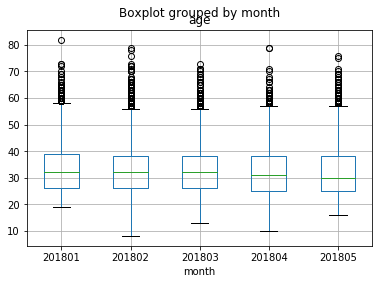

In [76]:
df.query('channel == "OSS" and age > 0').boxplot(column='age', by='month')

In [145]:
def last_2_month(df):
    month_list = df.month.unique()
    month_list.sort()
    try:
        return month_list[-1:-3:-1]  # list of last month and last 2 month
    except:
        print("Error ".format(month_list))
        return None

In [146]:
def t_test_last_mom(df, var):
    # find last month and last 2 month
    months = last_2_month(df)
    
    # Pair-wised t-test differenc in mean
    var_last = df.loc[(df.channel == "OSS") & (df.month == months[0]), [var]]
    var_last_2 = df.loc[(df.channel == "OSS") & (df.month == months[1]), [var]]
    test = stats.ttest_ind(var_last, var_last_2)
    
    # print test result
    print("{0} t-test month {1} with month {2}".format(var, months[0], months[1]))
    print("p-valus : {:.5f}".format(test.pvalue[0]))
    if test.pvalue[0] < 0.05:
        print("reject H0, {0} significantly difference {1} and {2}".format(var, months[0], months[1]))
    else:
        print("accept H0, {0} not significantly difference {1} and {2}".format(var, months[0], months[1]))
    return None

In [151]:
t_test_last_mom(df, "monthly_salary")

monthly_salary t-test month 201805 with month 201804
p-valus : 0.02263
reject H0, monthly_salary significantly difference 201805 and 201804


In [ ]:
import pandas.plotting as plotting
plotting.scatter_matrix(df[['age', 'monthly_salary', 'approve_amount']])

In [ ]:
import seaborn as sns
sns.pairplot(df, vars=['age', 'monthly_salary'], hue='result')

### Linear Regression

In [ ]:
# from statsmodels.formula.api import olsM
model = ols("approve_amount ~ result", df).fit()
model.summary()